# All imports necessary

In [1]:
import os

In [2]:
import sys

In [3]:
import lightgbm as lgb

In [4]:
import xgboost as xgb

In [5]:
import warnings

In [6]:
warnings.filterwarnings("ignore")

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import multiprocessing

In [10]:
sys.path.append('..')

In [11]:
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.metrics import auc

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
from sklearn.compose import ColumnTransformer

In [19]:
from sklearn.metrics import roc_curve

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from source.code.transformers.metafeaturesextractor import MetaFeaturesExtractor

In [23]:
from source.code.models.svdbasedrecommender import SVDBasedRecommender

In [24]:
from source.code.models.songfrequencybasedrecommender import SongFrequencyBasedRecommender

In [25]:
from source.code.models.factorizationmachinebasedrecommender import FactorizationMachineBasedRecommender

In [26]:
from source.code.models.lightgbmbasedrecommender import LightGBMBasedRecommender

In [27]:
from source.code.models.xgboostbasedrecommender import XGBoostBasedRecommender

In [28]:
from source.code.models.ensemblebasedrecommender import EnsembleBasedRecommender

# Auxiliary methods

In [29]:
def plot_roc_auc(fpr, tpr, classifier):
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example ({})'.format(classifier))
    plt.legend(loc="lower right")
    plt.show()

# Read the data

In [30]:
data_directory = '../data/datasets/'

In [31]:
unknown_category_label = 'unknown'

In [32]:
unknown_language_label = -1

## Train

In [33]:
train = pd.read_csv(os.path.join(data_directory, 'train.csv'), engine='python')

In [34]:
train.head(4).T

,0,1,2,3
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
source_system_tab,explore,my library,my library,my library
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more
source_type,online-playlist,local-playlist,local-playlist,local-playlist
target,1,1,1,1


In [35]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  7377418 non-null object
song_id               7377418 non-null object
source_system_tab     7352569 non-null object
source_screen_name    6962614 non-null object
source_type           7355879 non-null object
target                7377418 non-null int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


## Test

In [36]:
test = pd.read_csv(os.path.join(data_directory, 'test.csv'), engine='python')

In [37]:
test.head(4).T

,0,1,2,3
id,0,1,2,3
msno,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=
song_id,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=
source_system_tab,my library,my library,discover,radio
source_screen_name,Local playlist more,Local playlist more,NaN,Radio
source_type,local-library,local-library,song-based-playlist,radio


In [38]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
id                    2556790 non-null int64
msno                  2556790 non-null object
song_id               2556790 non-null object
source_system_tab     2548348 non-null object
source_screen_name    2393907 non-null object
source_type           2549493 non-null object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


## Songs

In [39]:
songs = pd.read_csv(os.path.join(data_directory, 'songs.csv'))

In [40]:
songs.head(4).T

,0,1,2,3
song_id,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=
song_length,247640,197328,231781,273554
genre_ids,465,444,465,465
artist_name,張信哲 (Jeff Chang),BLACKPINK,SUPER JUNIOR,S.H.E
composer,董貞,TEDDY| FUTURE BOUNCE| Bekuh BOOM,NaN,湯小康
lyricist,何啟弘,TEDDY,NaN,徐世珍
language,3,31,31,3


In [41]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
song_id        2296320 non-null object
song_length    2296320 non-null int64
genre_ids      2202204 non-null object
artist_name    2296320 non-null object
composer       1224966 non-null object
lyricist       351052 non-null object
language       2296319 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


## Members

In [42]:
members = pd.read_csv(os.path.join(data_directory, 'members.csv'))

In [43]:
members.head(4).T

,0,1,2,3
msno,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=
city,1,1,1,1
bd,0,0,0,0
gender,NaN,NaN,NaN,NaN
registered_via,7,7,4,9
registration_init_time,20110820,20150628,20160411,20150906
expiration_date,20170920,20170622,20170712,20150907


In [44]:
members.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
msno                      34403 non-null object
city                      34403 non-null int64
bd                        34403 non-null int64
gender                    14501 non-null object
registered_via            34403 non-null int64
registration_init_time    34403 non-null int64
expiration_date           34403 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


## Sample submission

In [45]:
sample_submission = pd.read_csv(os.path.join(data_directory, 'sample_submission.csv'))

In [46]:
sample_submission.head(4).T

,0,1,2,3
id,0.0,1.0,2.0,3.0
target,0.5,0.5,0.5,0.5


In [47]:
sample_submission.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 2 columns):
id        2556790 non-null int64
target    2556790 non-null float64
dtypes: float64(1), int64(1)
memory usage: 39.0 MB


# Solutions

## Train / Test split preparation

In [48]:
X, y = train[train.columns[:-1]], train[train.columns[-1]]

In [49]:
X_for_submission = test[test.columns]

In [50]:
X.head(4).T

,0,1,2,3
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
source_system_tab,explore,my library,my library,my library
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more
source_type,online-playlist,local-playlist,local-playlist,local-playlist


In [51]:
y.head(4).T

0    1
1    1
2    1
3    1
Name: target, dtype: int64

In [52]:
X_for_submission.head(4).T

,0,1,2,3
id,0,1,2,3
msno,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=
song_id,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=
source_system_tab,my library,my library,discover,radio
source_screen_name,Local playlist more,Local playlist more,NaN,Radio
source_type,local-library,local-library,song-based-playlist,radio


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [54]:
print(X_train.shape, y_train.shape)

(5164192, 5) (5164192,)


In [55]:
print(type(X_train), type(y_train))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [56]:
print(X_test.shape, y_test.shape)

(2213226, 5) (2213226,)


In [57]:
print(type(X_test), type(y_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


## Preprocessing steps description

In [58]:
categorical_features = [
    'source_system_tab',
    'source_screen_name',
    'city',
    'gender'
]

In [59]:
categorical_features_lang = [
    'language'
]

In [60]:
numerical_features = [
    'bd',
    'song_length'
]

In [61]:
numerical_features_days_reg = [
    'days_registered'
]

In [62]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [63]:
num_features_pipeline_days_reg = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('discretize', KBinsDiscretizer(n_bins=4, encode='onehot-dense'))
])

In [64]:
cat_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_category_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [65]:
cat_features_pipeline_lang = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=unknown_language_label)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, numerical_features),
        ('num_days_reg', num_features_pipeline_days_reg, numerical_features_days_reg),
        ('cat', cat_features_pipeline, categorical_features),
        ('cat_lang', cat_features_pipeline_lang, categorical_features_lang)
    ]
)

In [67]:
unified_pipeline = Pipeline(
    steps=[
        ('add_meta_info', MetaFeaturesExtractor(user_meta=members, item_meta=songs)),
        ('preprocessing', preprocessor)
    ]
)

## Naive frequency approach

In [68]:
naive_frequency_recommender = SongFrequencyBasedRecommender()

In [69]:
naive_frequency_recommender.fit(X_train, y_train)

SongFrequencyBasedRecommender()

In [70]:
y_pred = naive_frequency_recommender.predict_proba(X_test)

In [71]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

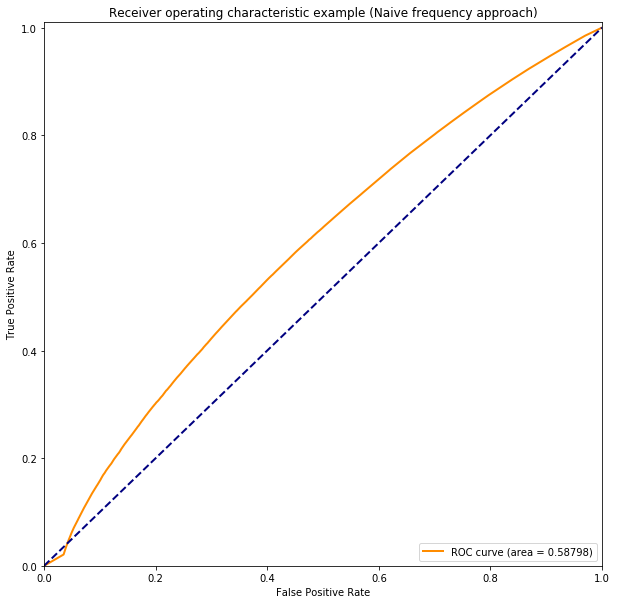

In [72]:
plot_roc_auc(fpr, tpr, 'Naive frequency approach')

## SVD

In [73]:
svd_recommender = SVDBasedRecommender()

In [74]:
svd_recommender.fit(X_train, y_train)

SVDBasedRecommender()

In [75]:
y_pred = svd_recommender.predict_proba(X_test)

In [76]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

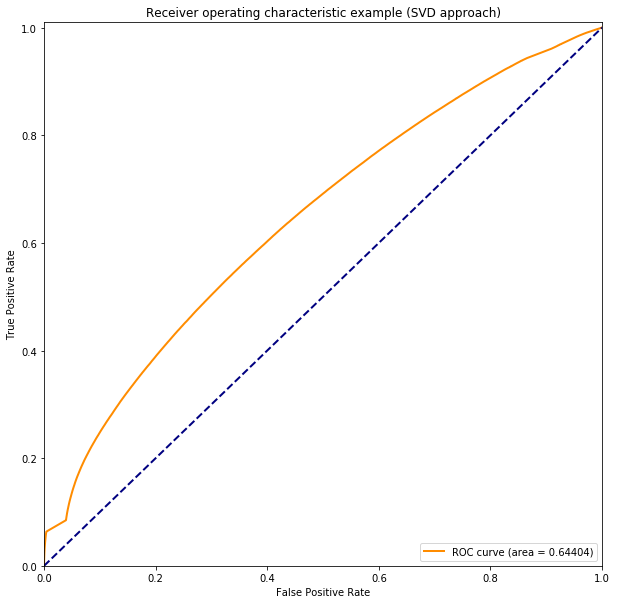

In [77]:
plot_roc_auc(fpr, tpr, 'SVD approach')

## FM

In [78]:
fm_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', FactorizationMachineBasedRecommender(show_progress=True))
    ]
)

In [79]:
fm_classifier_pipeline.fit(X_train, y_train.values)

100%|██████████| 100/100 [37:37<00:00, 22.45s/epoch]


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD..., ['language'])]))])), ('classification', FactorizationMachineBasedRecommender(show_progress=True))])

In [80]:
y_pred = fm_classifier_pipeline.predict_proba(X_test)

In [81]:
y_pred.shape

(2213226,)

In [82]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

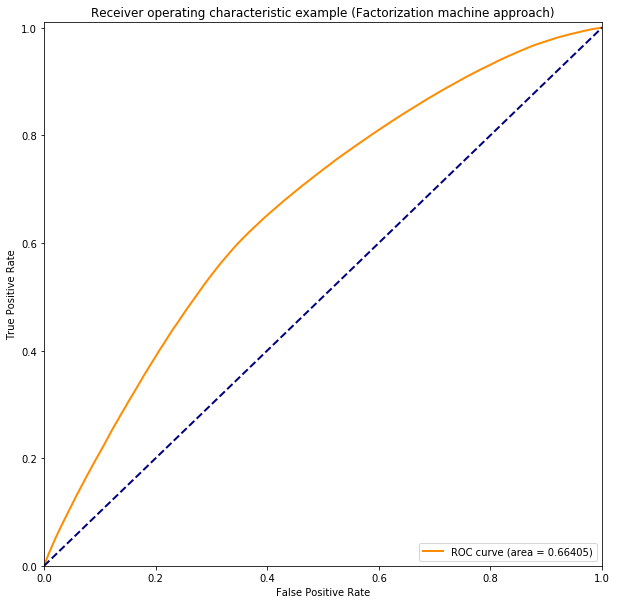

In [83]:
plot_roc_auc(fpr, tpr, 'Factorization machine approach')

## LightGBM

In [84]:
lgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', LightGBMBasedRecommender())
    ]
)

In [85]:
lgb_classifier_pipeline.fit(X_train, y_train.values)

Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD..., sparse=False))]), ['language'])]))])), ('classification', LightGBMBasedRecommender(val_size=0.3))])

In [86]:
y_pred = lgb_classifier_pipeline.predict_proba(X_test)

In [87]:
y_pred.shape

(2213226,)

In [88]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

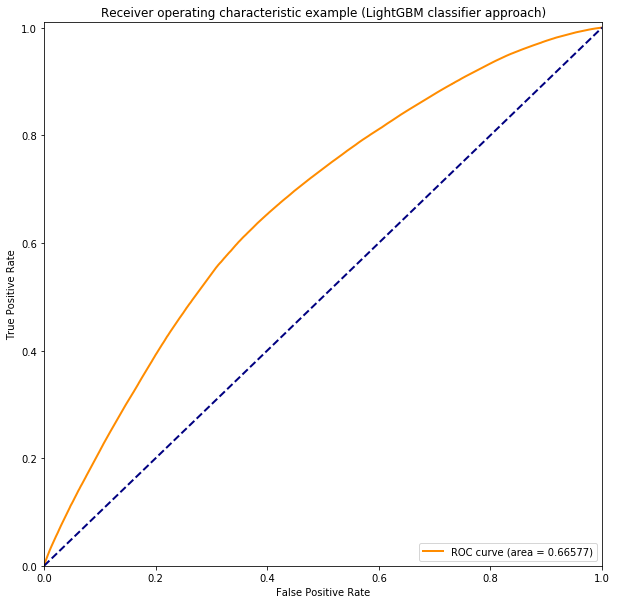

In [89]:
plot_roc_auc(fpr, tpr, 'LightGBM classifier approach')

## XGBoost

In [90]:
xgb_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', XGBoostBasedRecommender())
    ]
)

In [91]:
xgb_classifier_pipeline.fit(X_train, y_train.values)

[16:57:20] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD...e, sparse=False))]), ['language'])]))])), ('classification', XGBoostBasedRecommender(val_size=0.3))])

In [92]:
y_pred = xgb_classifier_pipeline.predict_proba(X_test)

In [93]:
y_pred.shape

(2213226,)

In [94]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

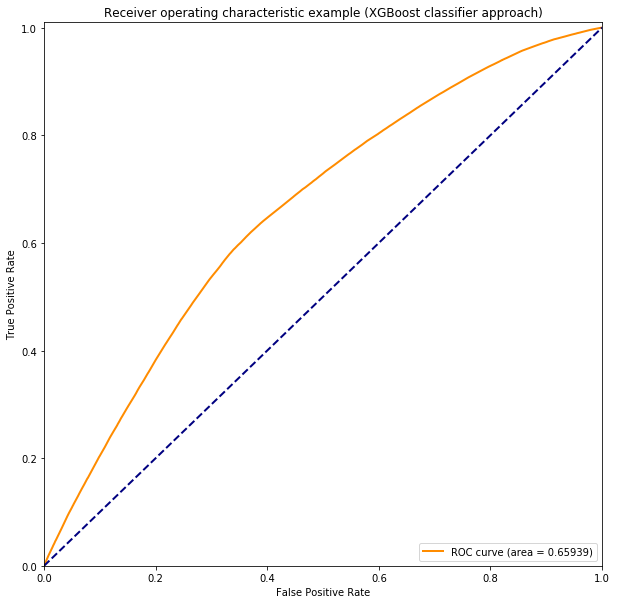

In [95]:
plot_roc_auc(fpr, tpr, 'XGBoost classifier approach')

## StarSpace

In [106]:
# TBD

## Ensemble

In [96]:
ens_classifier_pipeline = Pipeline(
    steps=[
        ('data_preparation', unified_pipeline),
        ('classification', EnsembleBasedRecommender(
            base_estimators=[
                FactorizationMachineBasedRecommender(),
                LightGBMBasedRecommender(),
                XGBoostBasedRecommender()
            ]
        ))
    ]
)

In [97]:
ens_classifier_pipeline.fit(X_train, y_train.values)

100%|██████████| 3/3 [23:56<00:00, 689.02s/it] 


Pipeline(memory=None,
     steps=[('data_preparation', Pipeline(memory=None,
     steps=[('add_meta_info', MetaFeaturesExtractor(item_meta=                                              song_id  song_length  \
0        CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640
1        o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZD...ecommender(val_size=0.3), XGBoostBasedRecommender(val_size=0.3)],
             ens_train_size=0.4))])

In [98]:
y_pred = ens_classifier_pipeline.predict_proba(X_test)

100%|██████████| 3/3 [00:07<00:00,  3.22s/it]


In [99]:
y_pred.shape

(2213226,)

In [100]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

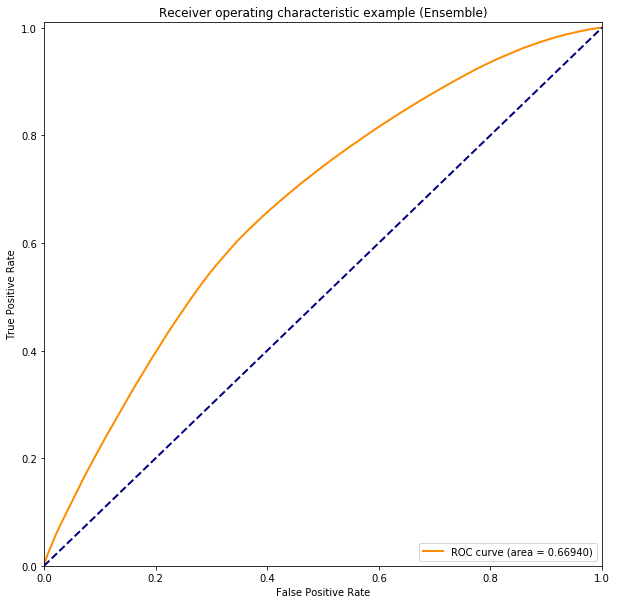

In [101]:
plot_roc_auc(fpr, tpr, 'Ensemble')

# Submission

In [102]:
y_pred_subm = ens_classifier_pipeline.predict_proba(X_for_submission)

100%|██████████| 3/3 [00:08<00:00,  3.68s/it]


In [103]:
y_pred_subm.shape

(2556790,)

In [104]:
X_for_submission['target'] = y_pred_subm

In [105]:
X_for_submission[['id', 'target']].to_csv(os.path.join(data_directory, 'ensemble_submission.csv'), index=False)

# Conclusion